In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(imputeLCMD)
    library(rrcovNA)

})


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")


ℹ Loading msImpute



In [2]:
dia <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD016647/Spike-in-biol-var-OT-SN-Report.txt", header = TRUE, stringsAsFactors = FALSE)


dia$experiment <- paste(dia$R.Condition, dia$R.Replicate,sep="_")
# table(dia$experiment)

# table(dia$R.Replicate)
# table(dia$R.Condition)
# table(grepl("UPS", dia$PG.ProteinAccessions))
# table(grepl("CON|REV", dia$PG.ProteinAccessions))
# table(grepl("ups", dia$PG.BGSFASTAHeader))
# table(grepl("iRT", dia$PG.BGSUniProtId))
# table(dia$SpikeIn=="True")

# table(dia$PG.BGSDatabase)
# sum(table(dia$PG.BGSDatabase)[grep("sp", names(table(dia$PG.BGSDatabase)), invert = TRUE)])

# hist(dia$EG.Qvalue)
# table(table(dia$EG.PrecursorId) > 25)

# table(dia$IsProteotypic, dia$EG.Qvalue < 0.1)

# keep1 <- (dia$IsProteotypic == "True")
keep2 <- (dia$EG.Qvalue < 0.1)

# table(keep1&keep2, dia$SpikeIn)


dia <- dia[keep2,]


# MS1 --------------
dia_ms1 <- tidyr::spread(dia[,c("experiment","EG.PrecursorId", "FG.NormalizedMS1PeakArea")], key = experiment, value = FG.NormalizedMS1PeakArea)

# hist(log2(data.matrix(dia_ms1[,-1]))) # the study says the limit of detection is 100, and they removed anything less
# # the limit of detection

# table(log2(data.matrix(dia_ms1[,-1])) < log2(100))


# MS2 --------------

dia_ms2 <- tidyr::spread(dia[,c("experiment","EG.PrecursorId", "FG.NormalizedMS2PeakArea")], key = experiment, value = FG.NormalizedMS2PeakArea)

# hist(log2(data.matrix(dia_ms2[,-1])))


dia_ms1[dia_ms1==1] <- NA
dia_ms2[dia_ms2==1] <- NA

# par(mfrow=c(1,2))
# pcv <- plotCV2(normalizeBetweenArrays(log2(data.matrix(dia_ms2[,-1]))), outlier = FALSE)
# mtext("MS2")
# pcv <- plotCV2(normalizeBetweenArrays(log2(data.matrix(dia_ms1[,-1]))), outlier = FALSE)
# mtext("MS1")

y_dia_ms2 <- log2(data.matrix(dia_ms2[,-1]))
rownames(y_dia_ms2) <- dia_ms2$EG.PrecursorId

keep <- rowSums(!is.na(y_dia_ms2)) >=4
table(keep)

y_dia_ms2 <- y_dia_ms2[keep,]
y_dda <- y_dia_ms2

keep
 FALSE   TRUE 
   578 131860 

In [3]:
ups <- unique(dia$EG.PrecursorId[dia$SpikeIn == "True"])

group <- gsub("(S[12345])_[1-9]",
              "\\1",
              colnames(y_dda))

design <- model.matrix(~ group)

### Imputation

In [4]:
y_msImpute <- msImpute(y_dda, 
                      method = "v2",
                       group = group)



y_msImpute_bary <- msImpute(y_dda, 
                        a= 0.2,
                       method = "v2-mnar",
                       group = group)




library(MSstats)
library(ggthemes)
#### msStats####
# input <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD016647/Spike-in-biol-var-OT-SN-Report.txt", header = TRUE, stringsAsFactors=FALSE) 


## the following is from MassIVE.quant
# input <- read.delim("/home/users/allstaff/hediyehzadeh.s/softImpute_low_rank_experimentation/data/Spike-in-biol-var-OT-SN-Report.txt", header = TRUE, stringsAsFactors=FALSE) 

# required columns 
# ProteinName, PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge, IsotopeLabelType, Condition, BioReplicate, Run, Intensity, F.ExcludedFromQuantification


# cann't manually map all columns, and the code based on instructions in the 4.4.1 vignette doesn't work!
# quant <- SpectronauttoMSstatsFormat(input, use_log_file = FALSE) 
# 
# 
# processed.quant <- dataProcess(quant,
#                                normalization = 'equalizeMedians',
#                                summaryMethod="TMP",
#                                cutoffCensored="minFeature",
#                                censoredInt="NA",
#                                MBimpute=TRUE,
#                                maxQuantileforCensored=0.999)


y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)




y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")




sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD016647dia_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])
# m <- paste0("_", m)

all(rownames(y_dda) == rownames(sOa_imps[[1]]))

rowsname <- rownames(y_dda)[rownames(y_dda) %in% m]

all(rownames(y_dda[rowsname,]) == rownames(sOa_imps[[1]][rowsname,]))

mats <- list(
             "KNN"= y_knn[rowsname,],
        
             "impSeq" = y_impSeq[rowsname,],
             
             "barycenter" = y_msImpute_bary[rowsname,],
             
             "baseline" = y_dda[rowsname,])





mats <- c(sOa_imps, mats)



Running msImpute version 2

Estimate distribution under MAR assumption

rank is 9

computing lambda0 ...

lambda0 is 32.3601458683278

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 10

computing lambda0 ...

lambda0 is 37.8659174976813

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



Cluster size 131860 broken into 99220 32640 
Cluster size 99220 broken into 31767 67453 
Cluster size 31767 broken into 22526 9241 
Cluster size 22526 broken into 13125 9401 
Cluster size 13125 broken into 7141 5984 
Cluster size 7141 broken into 3416 3725 
Cluster size 3416 broken into 14 3402 
Done cluster 14 
Cluster size 3402 broken into 1558 1844 
Cluster size 1558 broken into 35 1523 
Done cluster 35 
Cluster size 1523 broken into 1376 147 
Done cluster 1376 
Done cluster 147 
Done cluster 1523 
Done cluster 1558 
Cluster size 1844 broken into 1814 30 
Cluster size 1814 broken into 1812 2 
Cluster size 1812 broken into 894 918 
Done cluster 894 
Done cluster 918 
Done cluster 1812 
Done cluster 2 
Done cluster 1814 
Done cluster 30 
Done cluster 1844 
Done cluster 3402 
Done cluster 3416 
Cluster size 3725 broken into 3714 11 
Cluster size 3714 broken into 3666 48 
Cluster size 3666 broken into 3655 11 
Cluster size 3655 broken into 1192 2463 
Done cluster 1192 
Cluster size 2463

Warning message in rownames(y_dda) == rownames(sOa_imps[[1]]):
“longer object length is not a multiple of shorter object length”


[1] FALSE

[1] TRUE

### Differential expression

In [13]:
n_ups <- 500
fdr_thresh <- 0.05

topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")

   fit <- lmFit(E, design = design)
   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh,1,0)
  tp$isUPS <- ifelse(rownames(tp) %in% ups,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  
  


  fullTables[[names(mats)[i]]] <- data.frame(
    

    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      31     792
NotSig           0   85532   85501   85100   83838
Up           85532       0      31     401     902


processing Mice



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      25     955
NotSig           0   85532   85515   85104   83650
Up           85532       0      17     403     927


processing EM



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      30    1064
NotSig           1   85532   85507   85097   83372
Up           85531       0      25     405    1096


processing BPCA



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      31    1022
NotSig           1   85532   85507   85102   83414
Up           85531       0      25     399    1096


processing KNN



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       1      29     727
NotSig           0   85532   85507   85117   84046
Up           85532       0      24     386     759


processing impSeq



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      30    1027
NotSig           1   85532   85507   85100   83447
Up           85531       0      25     402    1058


processing barycenter



       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0       0       0      29     894
NotSig           0   85532   85507   85095   83669
Up           85532       0      25     408     969


processing baseline

Warning message:
“Partial NA coefficients for 2643 probe(s)”


       (Intercept) groupS2 groupS3 groupS4 groupS5
Down             0      10      15      87    1010
NotSig          21   84765   84720   84377   82351
Up           85511       2      54     427     833


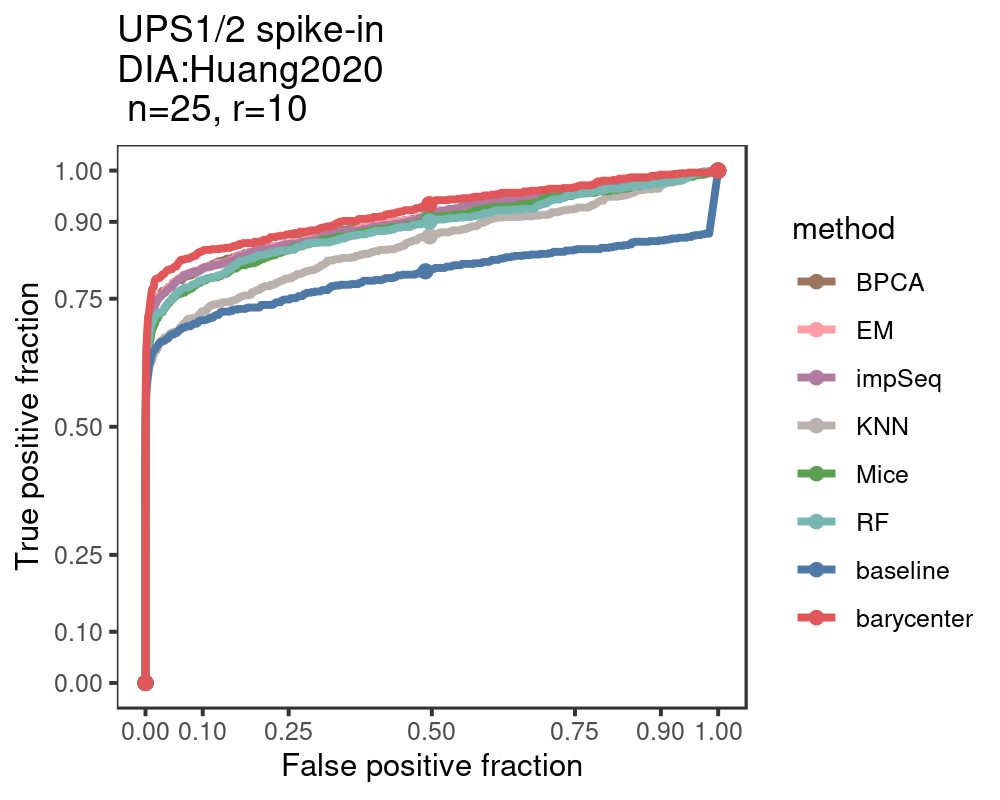

In [14]:
fig.size(4, 5)

library(plotROC)
library(patchwork)
library(ggthemes)


col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")


fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide = FALSE) + 
  scale_color_manual(values = col_pal) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()
       # legend.position = "none"
       )



fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


dataset_name = 'PXD016647'
print(p2 + labs(title = "UPS1/2 spike-in \nDIA:Huang2020\n n=25, r=10"))

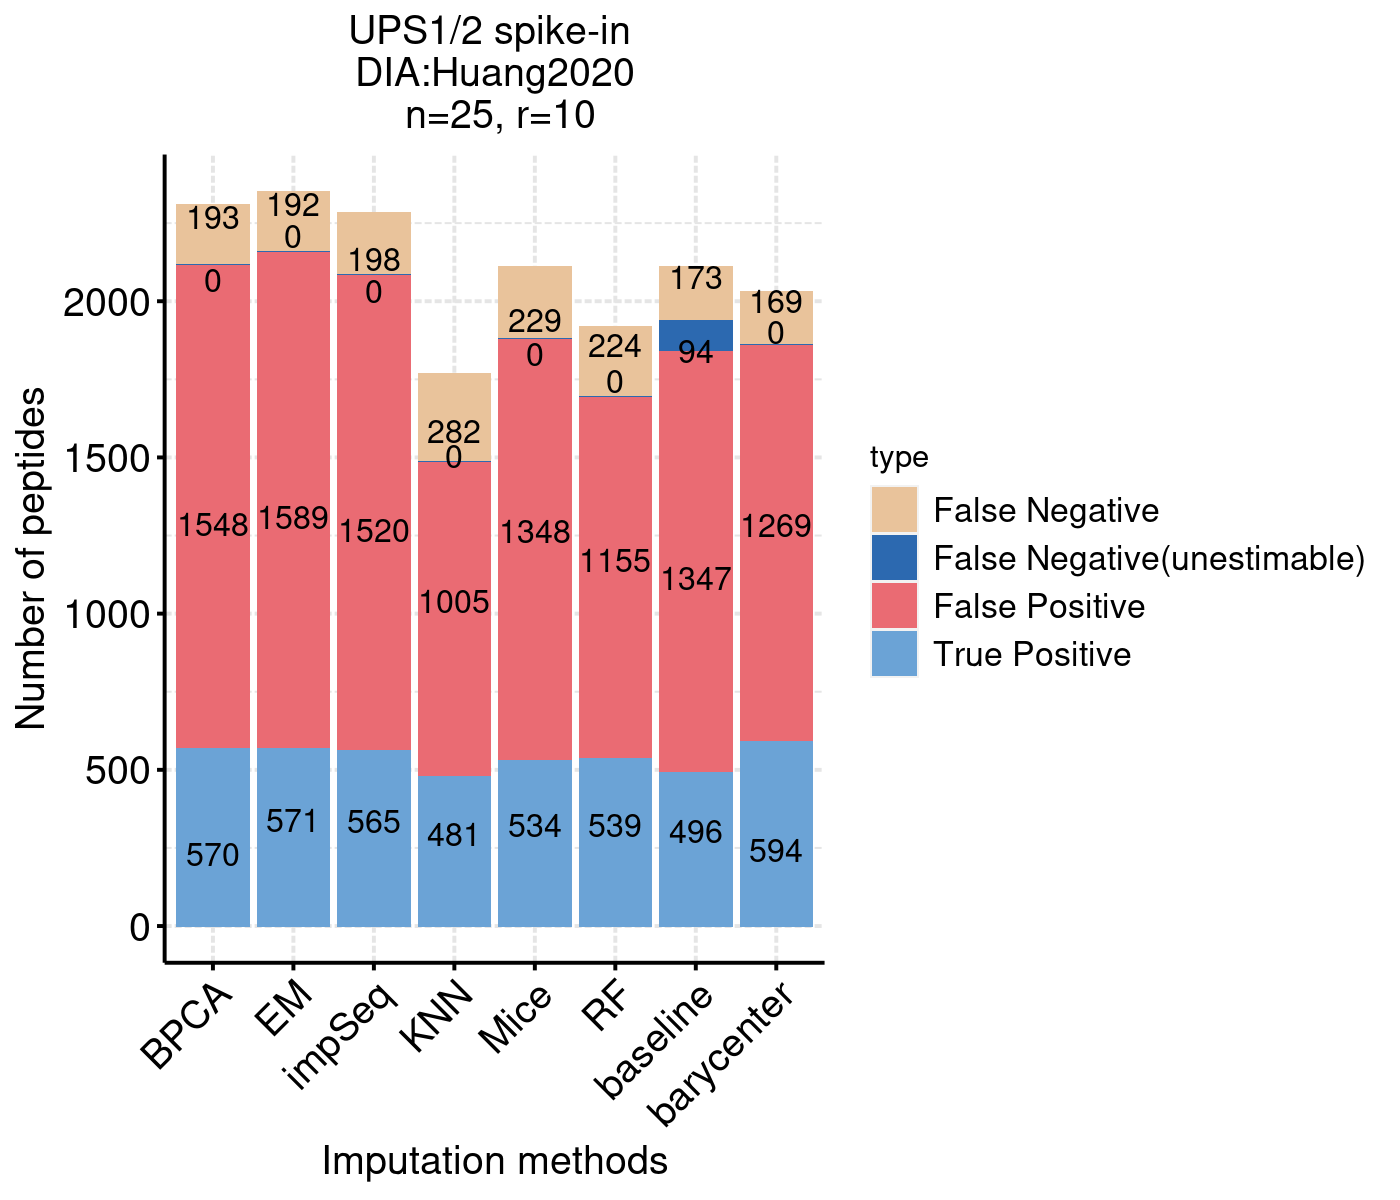

In [15]:
fig.size(6,7)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05
ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)




# png(file = "~/barplot_PXD016647.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "UPS1/2 spike-in \nDIA:Huang2020\n n=25, r=10") + 

  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p


 FALSE   TRUE 
127913   3947 

png 
  2

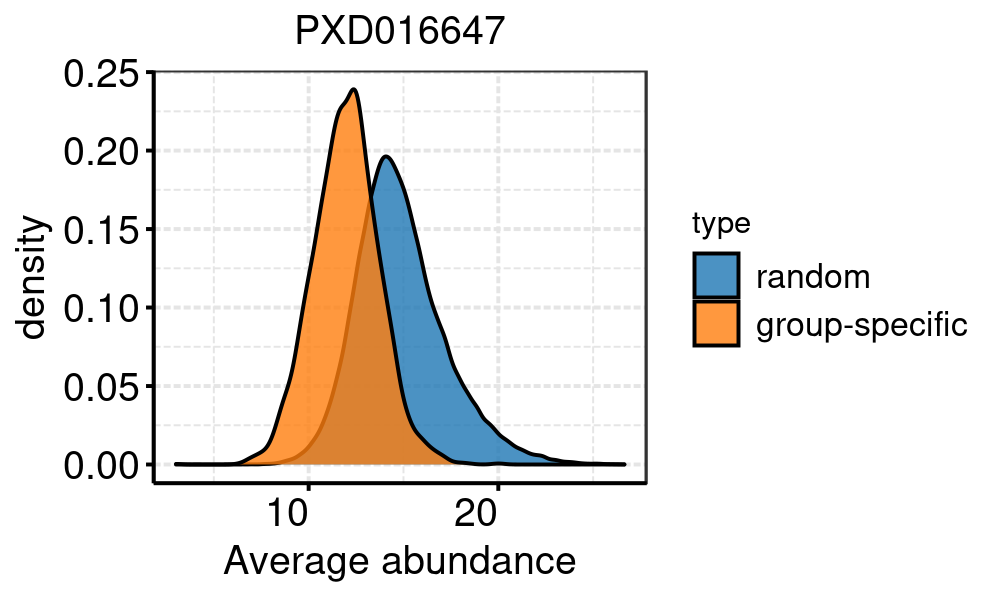

In [16]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD016647.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD016647", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

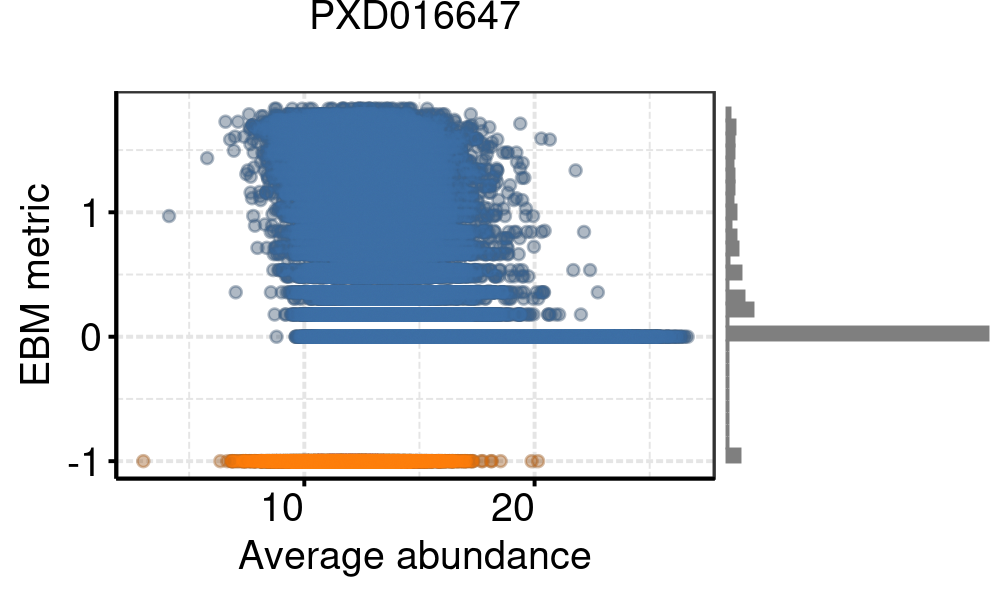

In [17]:
fig.size(3,5)

# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title='PXD016647')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PXD016647.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()
p1


 FALSE   TRUE 
127913   3947 

Warning message:
“position_dodge requires non-overlapping x intervals”


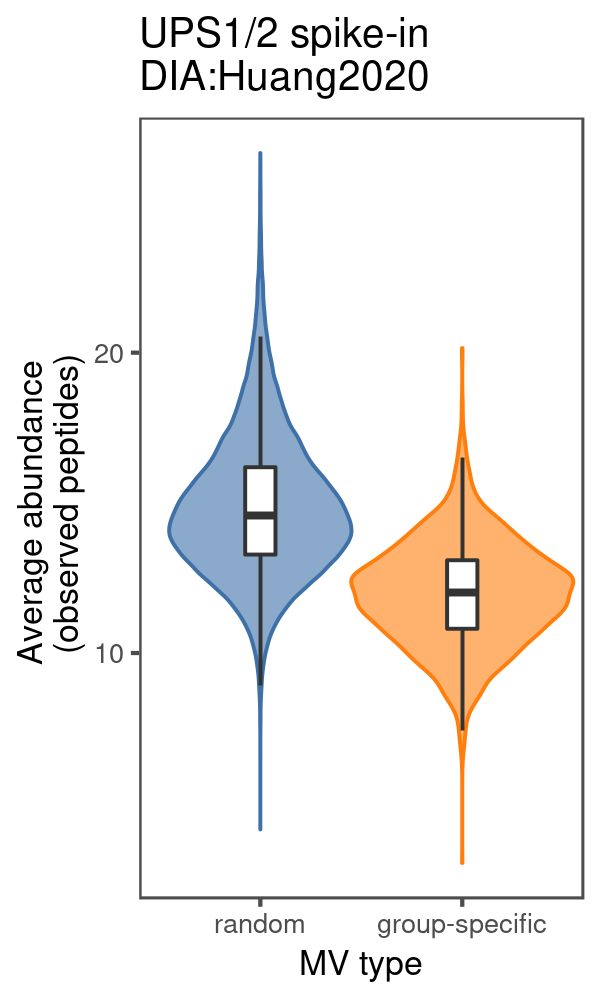

In [18]:
fig.size(5,3)
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))



# png(file = paste0("revision_figures/violin_",dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +
  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average abundance \n (observed peptides)', x = 'MV type',
       title = "UPS1/2 spike-in \nDIA:Huang2020") +
  theme_few() 

print(pv)


### Session information

In [19]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggExtra_0.9         plotROC_2.2.1       ggthemes_4.2.4     
 [4] MSstats_3.22.1      msImpute_1.7.1      rrcovNA_0.4-15     
 [7] rrcov_1.6-0         robustbase_0.93-7   imputeLCMD_2.0     
[10] impute_1.64.0    